In [1]:
import os
import json
from itertools import chain

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, entropy
import seaborn as sns

## Dataset preparation

In [2]:
# load LFW dataset face embeddings

if os.path.exists("../data/lfw_facenet_embeddings.parquet"):
    # try local path
    embedding_df = pd.read_parquet("../data/lfw_facenet_embeddings.parquet")
else:
    # download from Hugging Face
    embedding_df = pd.read_parquet("hf://datasets/lajota13/lfw_facenet_embeddings/lfw_facenet_embeddings.parquet")
    embedding_df.to_parquet("../data/lfw_facenet_embeddings.parquet")

embedding_df.head()

,original_path,label,embedding
0,data/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg,AJ_Cook,"[-0.04659934341907501, 0.0031754730734974146, ..."
1,data/lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg,AJ_Lamas,"[0.047449056059122086, -0.028084788471460342, ..."
2,data/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckh...,Aaron_Eckhart,"[-0.008572603575885296, -0.095662921667099, -0..."
3,data/lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_...,Aaron_Guiel,"[0.047885723412036896, -0.005329336039721966, ..."
4,data/lfw-deepfunneled/Aaron_Patterson/Aaron_Pa...,Aaron_Patterson,"[0.028689229860901833, 0.059540268033742905, -..."


In [3]:
# parse celebs names

embedding_df["name"] = embedding_df["label"].str.replace("_", " ")
embedding_df.drop(columns=["label"], inplace=True)

embedding_df.head()

,original_path,embedding,name
0,data/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg,"[-0.04659934341907501, 0.0031754730734974146, ...",AJ Cook
1,data/lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg,"[0.047449056059122086, -0.028084788471460342, ...",AJ Lamas
2,data/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckh...,"[-0.008572603575885296, -0.095662921667099, -0...",Aaron Eckhart
3,data/lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_...,"[0.047885723412036896, -0.005329336039721966, ...",Aaron Guiel
4,data/lfw-deepfunneled/Aaron_Patterson/Aaron_Pa...,"[0.028689229860901833, 0.059540268033742905, -...",Aaron Patterson


In [4]:
# load seasonal color analysis annotations

with open("../data/celebrities.json") as fid:
  annotations = json.load(fid)
annotations_df = pd.DataFrame(list(chain(*[[{"name": c, "season":  season} for c in celebs] for season, celebs in annotations.items()])))
annotations_df["macroseason"] = annotations_df["season"].str.extract("[a-z]+-([a-z]+)-[a-z]+")

annotations_df.head()

,name,season,macroseason
0,Emmy Rossum,bright-spring-celebrities,spring
1,Sonam K Ahuja,bright-spring-celebrities,spring
2,Lu Huang,bright-spring-celebrities,spring
3,Solange,bright-spring-celebrities,spring
4,Dan Stevens,bright-spring-celebrities,spring


In [5]:
# associate annotations to embeddings

embedding_annotated_df = embedding_df.merge(annotations_df, on="name", how="left")
macrolabel_map_df = pd.DataFrame(
    {
        "macrolabel": [0, 1, 2, 3],
        "macroseason": ["winter", "summer", "spring", "autumn"]
    }
)
embedding_annotated_df = embedding_annotated_df.merge(macrolabel_map_df, on="macroseason", how="left")
embedding_annotated_df["macrolabel"] = embedding_annotated_df["macrolabel"].fillna(-1)
embedding_annotated_df["macrolabel"] = embedding_annotated_df["macrolabel"].astype(int)

embedding_annotated_df.head()

,original_path,embedding,name,season,macroseason,macrolabel
0,data/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg,"[-0.04659934341907501, 0.0031754730734974146, ...",AJ Cook,NaN,NaN,-1
1,data/lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg,"[0.047449056059122086, -0.028084788471460342, ...",AJ Lamas,NaN,NaN,-1
2,data/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckh...,"[-0.008572603575885296, -0.095662921667099, -0...",Aaron Eckhart,true-spring-celebrities,spring,2
3,data/lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_...,"[0.047885723412036896, -0.005329336039721966, ...",Aaron Guiel,NaN,NaN,-1
4,data/lfw-deepfunneled/Aaron_Patterson/Aaron_Pa...,"[0.028689229860901833, 0.059540268033742905, -...",Aaron Patterson,NaN,NaN,-1


In [6]:
embedding_annotated_df["macrolabel"].value_counts()

macrolabel
-1    12629
 3      269
 0      139
 1      129
 2       67
Name: count, dtype: int64

In [7]:
# splitting dataset into labeled and unlabeled records (in order to sample the test set 
# from the labeled portion of the dataset)

labeled_df = embedding_annotated_df.loc[embedding_annotated_df["macrolabel"] != -1, :].copy()
unlabeled_df = embedding_annotated_df.loc[embedding_annotated_df["macrolabel"] == -1, :].copy()

In [8]:
# build a balanced training set
N = 50
train_df = labeled_df.groupby(
    "macrolabel"
).sample(N, random_state=42)

test_df = labeled_df.loc[labeled_df.index.difference(train_df.index), :]
train_df = pd.concat([train_df, unlabeled_df], axis=0)
print("Training label distribution:")
print(train_df["macrolabel"].value_counts())
print("Test label distribution:")
print(test_df["macrolabel"].value_counts())

Training label distribution:
macrolabel
-1    12629
 0       50
 1       50
 2       50
 3       50
Name: count, dtype: int64
Test label distribution:
macrolabel
3    219
0     89
1     79
2     17
Name: count, dtype: int64


In [9]:
# build numpy arrays representing the dataset splits

X_train = np.vstack(train_df["embedding"].tolist())
y_train = train_df["macrolabel"].values.astype(np.int8)
X_test = np.vstack(test_df["embedding"].tolist())
y_test = test_df["macrolabel"].values.astype(np.int8)

## Label propagation

In [10]:
N = 20
rs = RandomizedSearchCV(
    estimator=LabelSpreading(kernel="knn"), 
    param_distributions={
        "n_neighbors": range(5, 20),
        "alpha": loguniform(0.2, 0.9)
    },
    n_iter=N,
    scoring=lambda ls, X, y: ls.score(X[y > -1], y[y > -1]), 
    random_state=42
)

rs.fit(X_train, y_train)


/home/giacomo/src/seasonal-color-analysis/.venv/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/home/giacomo/src/seasonal-color-analysis/.venv/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/home/giacomo/src/seasonal-color-analysis/.venv/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/home/giacomo/src/seasonal-color-analysis/.venv/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
/home/giacomo/src/seasonal-color-analysis/.venv/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value en

RandomizedSearchCV(estimator=LabelSpreading(kernel='knn'), n_iter=20,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f7b2fc18a00>,
                                        'n_neighbors': range(5, 20)},
                   random_state=42,
                   scoring=<function <lambda> at 0x7f7b2fef96c0>)

Best score: 0.79
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        89
           1       0.61      0.84      0.71        79
           2       0.38      0.88      0.54        17
           3       0.92      0.78      0.84       219

    accuracy                           0.78       404
   macro avg       0.71      0.81      0.72       404
weighted avg       0.84      0.78      0.80       404



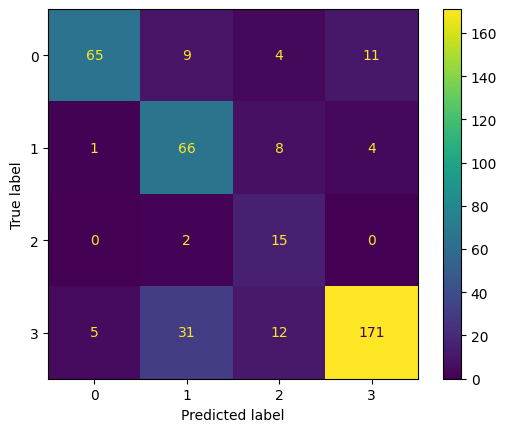

In [11]:
print(f"Best score: {rs.best_score_}")
ls =  rs.best_estimator_
y_pred = ls.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

In [12]:
# dump propagated labels

unlabeled_df["macrolabel"] = (ls.predict(np.vstack(unlabeled_df["embedding"].tolist()))).astype(np.int8)
unlabeled_df = unlabeled_df.drop(columns="macroseason").merge(macrolabel_map_df, on="macrolabel", how="left")
label_propagated_df = pd.concat([labeled_df, unlabeled_df])
label_propagated_df.to_parquet("../data/lfw_facenet_embeddings_label_spreading.parquet")

/home/giacomo/src/seasonal-color-analysis/.venv/lib/python3.10/site-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [13]:
# analysing label distribution

label_propagated_df["macroseason"].value_counts()

macroseason
winter    4680
summer    3211
autumn    2909
spring    2433
Name: count, dtype: int64

In [17]:
# save embedding and labels for visualization in the TF embedding projector (https://projector.tensorflow.org/)
LOGDIR = "../data/embedding_projector_label_spreading"
if not os.path.isdir(LOGDIR):
    os.mkdir(LOGDIR)

np.savetxt(
    os.path.join(LOGDIR, "embeddings.tsv"), 
    np.vstack(label_propagated_df["embedding"].tolist()), 
    delimiter="\t"
)

label_propagated_df[["macroseason", "name"]].to_csv(
    os.path.join(LOGDIR, "metadata.tsv"), 
    sep="\t"
    )

In order to inspect the embedding and the inferred labels you can visit 

https://projector.tensorflow.org/?config=https://raw.githubusercontent.com/lajota13/seasonal-color-analysis/master/data/embedding_projector_label_spreading/projector_config.json 

In [18]:
# analysis of the prediction entropy

label_entropy_df = label_propagated_df["name"].value_counts().to_frame().merge(
    label_propagated_df.groupby("name")["macroseason"].apply(
        lambda s: entropy(s.value_counts().values, base=2)
        ).to_frame().rename(
            columns={"macroseason": "entropy"}
        ),
        on="name"
)


<Axes: xlabel='count', ylabel='entropy'>

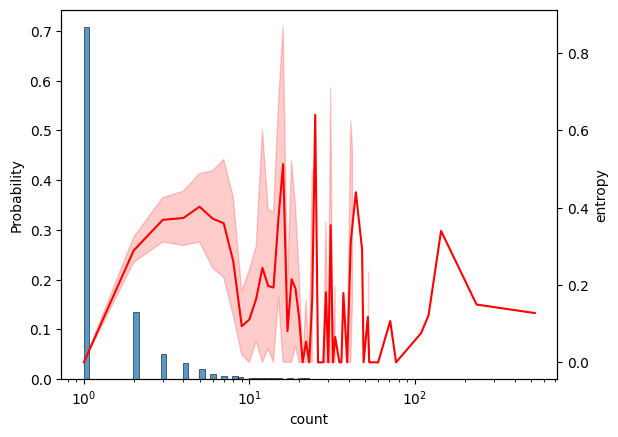

In [19]:
fig, ax1 = plt.subplots() # initializes figure and plots
ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis
sns.histplot(label_entropy_df, x="count", ax=ax1, log_scale=True, stat="probability")
sns.lineplot(label_entropy_df, x="count", y="entropy", ax=ax2, c="r")